# Statistical Evaluation of SG-FIGS Experiment Results

Rigorous statistical evaluation of the SG-FIGS (Synergy-Guided FIGS) experiment across 7 binary classification benchmarks. This notebook implements 7 analyses:

1. **Friedman test** with Nemenyi post-hoc for overall method ranking
2. **Wilcoxon signed-rank** pairwise tests between methods
3. **Criterion 1**: Per-dataset accuracy + complexity assessment
4. **Criterion 2**: Interpretability score diagnostic
5. **Criterion 3**: Domain analysis of synergy pairs
6. **Pareto frontier** analysis (accuracy vs complexity tradeoff)
7. **Synergy landscape correlation** — which synergy features predict SG-FIGS benefit

**Methods compared**: FIGS (baseline), RO-FIGS (Random Oblique), SG-FIGS (Synergy-Guided)

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# numpy, scipy, matplotlib — pre-installed on Colab, install locally only
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'scipy==1.16.3', 'matplotlib==3.10.0')


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [2]:
import json
import os
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({"font.size": 11})

## Data Loading

Load pre-computed experiment results: mean balanced accuracy, mean splits, synergy landscape features, and domain knowledge for 7 binary classification benchmarks.

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-b88b52-synergy-guided-oblique-splits-using-part/main/evaluation_iter3_statistical_eva/demo/mini_demo_data.json"

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()

acc_per_dataset = data["accuracy_matrix"]
splits_per_dataset = data["splits_per_dataset"]
synergy_data = data["synergy_data"]
synergy_pairs = data["synergy_pairs"]
dataset_metadata = data["dataset_metadata"]
domain_knowledge = data["domain_knowledge"]

print(f"Loaded data for {len(acc_per_dataset)} datasets")
for ds in acc_per_dataset:
    print(f"  {ds}: FIGS={acc_per_dataset[ds]['FIGS']:.4f}, "
          f"RO-FIGS={acc_per_dataset[ds]['RO-FIGS']:.4f}, "
          f"SG-FIGS={acc_per_dataset[ds]['SG-FIGS']:.4f}")

Loaded data for 7 datasets
  breast_cancer_wisconsin_diagnostic: FIGS=0.9119, RO-FIGS=0.9533, SG-FIGS=0.9382
  pima_diabetes: FIGS=0.7090, RO-FIGS=0.7127, SG-FIGS=0.7069
  heart_statlog: FIGS=0.7829, RO-FIGS=0.7628, SG-FIGS=0.7464
  ionosphere: FIGS=0.8633, RO-FIGS=0.9028, SG-FIGS=0.8994
  sonar: FIGS=0.7355, RO-FIGS=0.7790, SG-FIGS=0.7889
  banknote: FIGS=0.9793, RO-FIGS=0.9889, SG-FIGS=0.9905
  spectf_heart: FIGS=0.8562, RO-FIGS=0.8624, SG-FIGS=0.8008


## Configuration

Tunable parameters for the statistical evaluation — thresholds, method names, and analysis settings.

In [5]:
# ---------------------------------------------------------------------------
# Config: tunable parameters
# ---------------------------------------------------------------------------
METHODS = ["FIGS", "RO-FIGS", "SG-FIGS"]

# Criterion 1 thresholds
ACC_DELTA_THRESHOLD = 0.01       # |acc_delta| <= this means competitive accuracy
SPLIT_RATIO_THRESHOLD = 0.80     # split_ratio <= this means 20% fewer splits
ALT_ACC_THRESHOLD = 0.01         # acc_delta > this for alternative criterion
ALT_SPLIT_RATIO = 1.10           # split_ratio <= this for alternative criterion

# Criterion 3 thresholds
TOP_K_SYNERGY_PAIRS = 5          # number of top synergy pairs to analyze per dataset
MIN_MEANINGFUL_PAIRS = 2         # at least this many of top-K must be meaningful
MIN_MEANINGFUL_DATASETS = 3      # at least this many datasets must have meaningful pairs

# Nemenyi critical values for k=3 methods
NEMENYI_Q_005 = 2.343
NEMENYI_Q_010 = 2.052

## Analysis 1: Friedman Test with Nemenyi Post-Hoc

Non-parametric test for comparing rankings of 3 methods across 7 datasets. The Friedman test checks if at least one method differs significantly in rank. If significant, the Nemenyi post-hoc test identifies which specific pairs differ.

In [6]:
# ---------------------------------------------------------------------------
# 1. Friedman Test with Nemenyi Post-Hoc
# ---------------------------------------------------------------------------
complete_datasets = [ds for ds in acc_per_dataset
                     if all(m in acc_per_dataset[ds] for m in METHODS)]
N = len(complete_datasets)
k = len(METHODS)
print(f"Using {N} datasets with all {k} methods: {complete_datasets}")

# Build accuracy matrix: N x k
acc_matrix = np.zeros((N, k))
for i, ds_name in enumerate(complete_datasets):
    for j, method in enumerate(METHODS):
        acc_matrix[i, j] = acc_per_dataset[ds_name][method]

# Compute ranks per dataset (higher accuracy = lower rank = better)
rank_matrix = np.zeros((N, k))
for i in range(N):
    rank_matrix[i] = stats.rankdata(-acc_matrix[i], method="average")

avg_ranks = np.mean(rank_matrix, axis=0)
print(f"\nAverage ranks: {dict(zip(METHODS, avg_ranks.tolist()))}")

# Friedman test
stat, p_value = stats.friedmanchisquare(*[acc_matrix[:, j] for j in range(k)])
print(f"Friedman chi2={stat:.4f}, p={p_value:.6f}")
print(f"Significant at 0.05: {p_value < 0.05}")
print(f"Significant at 0.10: {p_value < 0.10}")

# Nemenyi post-hoc
if p_value < 0.10:
    cd_005 = NEMENYI_Q_005 * np.sqrt(k * (k + 1) / (6 * N))
    cd_010 = NEMENYI_Q_010 * np.sqrt(k * (k + 1) / (6 * N))
    print(f"\nNemenyi CD (alpha=0.05): {cd_005:.4f}")
    print(f"Nemenyi CD (alpha=0.10): {cd_010:.4f}")
    for i_m in range(k):
        for j_m in range(i_m + 1, k):
            rd = abs(avg_ranks[i_m] - avg_ranks[j_m])
            print(f"  {METHODS[i_m]} vs {METHODS[j_m]}: rank_diff={rd:.4f}, "
                  f"sig_005={rd > cd_005}, sig_010={rd > cd_010}")
else:
    print("\nFriedman test not significant — Nemenyi post-hoc not warranted")

Using 7 datasets with all 3 methods: ['breast_cancer_wisconsin_diagnostic', 'pima_diabetes', 'heart_statlog', 'ionosphere', 'sonar', 'banknote', 'spectf_heart']

Average ranks: {'FIGS': 2.4285714285714284, 'RO-FIGS': 1.4285714285714286, 'SG-FIGS': 2.142857142857143}
Friedman chi2=3.7143, p=0.156118
Significant at 0.05: False
Significant at 0.10: False

Friedman test not significant — Nemenyi post-hoc not warranted


## Analysis 2: Wilcoxon Signed-Rank Pairwise Tests

Paired non-parametric test for each method pair. Note that with N=7 datasets, the minimum achievable p-value is 1/2^7 ≈ 0.0078, limiting statistical power.

In [7]:
# ---------------------------------------------------------------------------
# 2. Wilcoxon Signed-Rank Pairwise Tests
# ---------------------------------------------------------------------------
print(f"Using {N} datasets, min achievable p-value = {1 / (2**N):.4f}\n")

pairs_to_test = [("FIGS", "RO-FIGS"), ("FIGS", "SG-FIGS"), ("RO-FIGS", "SG-FIGS")]
wilcoxon_results = {}

for m1, m2 in pairs_to_test:
    diffs = np.array([acc_per_dataset[ds][m1] - acc_per_dataset[ds][m2]
                       for ds in complete_datasets])
    mean_diff = float(np.mean(diffs))
    std_diff = float(np.std(diffs, ddof=1)) if len(diffs) > 1 else 0.0

    try:
        stat_val, p_val = stats.wilcoxon(diffs, alternative="two-sided", method="exact")
        test_ok = True
    except ValueError:
        stat_val, p_val = float("nan"), 1.0
        test_ok = False

    wilcoxon_results[f"{m1}_vs_{m2}"] = {
        "mean_diff": mean_diff, "p_value": p_val, "statistic": stat_val
    }
    direction = "better" if mean_diff > 0 else "worse"
    print(f"{m1} vs {m2}: mean_diff={mean_diff:+.6f}, "
          f"stat={stat_val}, p={p_val:.6f}")
    print(f"  → {m1} is {direction} than {m2} by {abs(mean_diff):.4f}"
          f"{' (significant at 0.05)' if test_ok and p_val < 0.05 else ''}\n")

Using 7 datasets, min achievable p-value = 0.0078

FIGS vs RO-FIGS: mean_diff=-0.017697, stat=4.0, p=0.109375
  → FIGS is worse than RO-FIGS by 0.0177

FIGS vs SG-FIGS: mean_diff=-0.004722, stat=13.0, p=0.937500
  → FIGS is worse than SG-FIGS by 0.0047

RO-FIGS vs SG-FIGS: mean_diff=+0.012975, stat=5.0, p=0.156250
  → RO-FIGS is better than SG-FIGS by 0.0130



## Analysis 3: Criterion 1 — Accuracy + Complexity Assessment

For each dataset, check if SG-FIGS achieves competitive accuracy (`|acc_delta| ≤ 0.01`) with at least 20% fewer splits (`split_ratio ≤ 0.80`) compared to RO-FIGS. An alternative pass condition: significantly higher accuracy at similar complexity.

In [8]:
# ---------------------------------------------------------------------------
# 3. Criterion 1: Per-Dataset Accuracy + Complexity Assessment
# ---------------------------------------------------------------------------
eligible = [ds for ds in acc_per_dataset
            if "SG-FIGS" in acc_per_dataset[ds] and "RO-FIGS" in acc_per_dataset[ds]]

c1_results = {}
meets_both = 0
meets_alt = 0

for ds in eligible:
    sg_acc = acc_per_dataset[ds]["SG-FIGS"]
    ro_acc = acc_per_dataset[ds]["RO-FIGS"]
    sg_spl = splits_per_dataset[ds]["SG-FIGS"]
    ro_spl = splits_per_dataset[ds]["RO-FIGS"]
    figs_acc = acc_per_dataset[ds].get("FIGS")
    figs_spl = splits_per_dataset[ds].get("FIGS", 0)

    acc_delta = sg_acc - ro_acc
    split_ratio = sg_spl / ro_spl if ro_spl > 0 else float("inf")
    acc_ok = abs(acc_delta) <= ACC_DELTA_THRESHOLD
    splits_ok = split_ratio <= SPLIT_RATIO_THRESHOLD
    alt_ok = acc_delta > ALT_ACC_THRESHOLD and split_ratio <= ALT_SPLIT_RATIO

    if acc_ok and splits_ok:
        assessment = "PASS_MAIN"
        meets_both += 1
    elif alt_ok:
        assessment = "PASS_ALT"
        meets_alt += 1
    else:
        assessment = "FAIL"

    c1_results[ds] = {"acc_delta": acc_delta, "split_ratio": split_ratio,
                       "assessment": assessment}
    print(f"  {ds}: Δacc={acc_delta:+.4f}, split_ratio={split_ratio:.2f} → {assessment}")

print(f"\nSummary: {meets_both}/{len(eligible)} pass main, "
      f"{meets_alt}/{len(eligible)} pass alternative, "
      f"{meets_both + meets_alt}/{len(eligible)} pass either")

  breast_cancer_wisconsin_diagnostic: Δacc=-0.0151, split_ratio=1.67 → FAIL
  pima_diabetes: Δacc=-0.0057, split_ratio=2.50 → FAIL
  heart_statlog: Δacc=-0.0164, split_ratio=0.33 → FAIL
  ionosphere: Δacc=-0.0034, split_ratio=0.50 → PASS_MAIN
  sonar: Δacc=+0.0098, split_ratio=1.67 → FAIL
  banknote: Δacc=+0.0015, split_ratio=0.33 → PASS_MAIN
  spectf_heart: Δacc=-0.0616, split_ratio=1.00 → FAIL

Summary: 2/7 pass main, 0/7 pass alternative, 2/7 pass either


## Analysis 4: Criterion 2 — Interpretability Score Diagnostic

Diagnoses why most datasets scored 0.000 on `split_interpretability_score`. Analyzes feature-index mismatch from MI prefiltering, axis-aligned fallback in low-complexity models, and PID method effects.

In [9]:
# ---------------------------------------------------------------------------
# 4. Criterion 2: Interpretability Score Diagnostic
# ---------------------------------------------------------------------------
c2_results = {}
n_mismatch = 0
n_high_dim = 0
n_low_complexity = 0

for ds_name, meta in dataset_metadata.items():
    n_features = meta["n_features"]
    n_used = meta["n_features_used_in_synergy"]
    is_high_dim = meta["is_high_dim"]
    mismatch = meta["feature_index_mismatch_likely"]
    sg_splits = meta["mean_sg_figs_splits"]

    causes = []
    if mismatch:
        n_mismatch += 1
        causes.append(f"Feature-index mismatch: {n_features} features → "
                       f"top-{n_used} selected by MI prefiltering")
    if is_high_dim:
        n_high_dim += 1
        causes.append(f"High-dim ({n_features} features, PID={meta['pid_method']})")
    if sg_splits <= 5:
        n_low_complexity += 1
        causes.append(f"Low complexity (SG-FIGS splits={sg_splits:.0f}): "
                       "axis-aligned fallback likely")

    c2_results[ds_name] = causes
    status = "⚠️" if causes else "✓"
    print(f"  {status} {ds_name}: {'; '.join(causes) if causes else 'no issues'}")

print(f"\nSummary: {n_mismatch} with index mismatch, "
      f"{n_high_dim} high-dim, {n_low_complexity} low-complexity")

  ⚠️ breast_cancer_wisconsin_diagnostic: High-dim (30 features, PID=MMI)
  ✓ pima_diabetes: no issues
  ⚠️ heart_statlog: Low complexity (SG-FIGS splits=5): axis-aligned fallback likely
  ⚠️ ionosphere: Feature-index mismatch: 34 features → top-30 selected by MI prefiltering; High-dim (34 features, PID=MMI); Low complexity (SG-FIGS splits=5): axis-aligned fallback likely
  ⚠️ sonar: Feature-index mismatch: 60 features → top-30 selected by MI prefiltering; High-dim (60 features, PID=MMI)
  ⚠️ banknote: Low complexity (SG-FIGS splits=5): axis-aligned fallback likely
  ⚠️ spectf_heart: Feature-index mismatch: 44 features → top-30 selected by MI prefiltering; High-dim (44 features, PID=MMI)

Summary: 3 with index mismatch, 4 high-dim, 3 low-complexity


## Analysis 5: Criterion 3 — Domain Analysis of Synergy Pairs

Maps top-5 synergy pairs per dataset to domain knowledge. Checks whether ≥ 3 datasets have domain-meaningful synergistic feature pairs (e.g., BMI×age in diabetes, cholesterol×ST-depression in heart disease).

In [10]:
# ---------------------------------------------------------------------------
# 5. Criterion 3: Domain Analysis of Synergy Pairs
# ---------------------------------------------------------------------------
datasets_with_meaningful = 0
c3_results = {}

for ds_name in synergy_pairs:
    top_k = synergy_pairs[ds_name][:TOP_K_SYNERGY_PAIRS]
    dk = domain_knowledge.get(ds_name, {})
    known = dk.get("known_interactions", {})
    domain = dk.get("domain", "unknown")

    meaningful_count = 0
    for pair in top_k:
        fi, fj = pair["feature_i"], pair["feature_j"]
        # Check both orderings using __ separator from the data format
        key1 = f"{fi}__{fj}"
        key2 = f"{fj}__{fi}"
        if key1 in known or key2 in known:
            meaningful_count += 1

    has_meaningful = meaningful_count >= MIN_MEANINGFUL_PAIRS
    if has_meaningful:
        datasets_with_meaningful += 1

    c3_results[ds_name] = {
        "domain": domain, "meaningful": meaningful_count,
        "total": len(top_k), "pass": has_meaningful
    }
    status = "PASS" if has_meaningful else "FAIL"
    print(f"  {ds_name} ({domain}): {meaningful_count}/{len(top_k)} "
          f"domain-meaningful → {status}")

criterion_met = datasets_with_meaningful >= MIN_MEANINGFUL_DATASETS
print(f"\n{datasets_with_meaningful}/{len(c3_results)} datasets with meaningful pairs "
      f"(threshold ≥ {MIN_MEANINGFUL_DATASETS}). Criterion {'MET' if criterion_met else 'NOT MET'}.")

  pima_diabetes (medical): 5/5 domain-meaningful → PASS
  breast_cancer_wisconsin_diagnostic (medical): 5/5 domain-meaningful → PASS
  heart_statlog (medical): 5/5 domain-meaningful → PASS
  banknote (signal_processing): 3/5 domain-meaningful → PASS
  ionosphere (radar): 1/5 domain-meaningful → FAIL
  sonar (sonar): 1/5 domain-meaningful → FAIL
  spectf_heart (medical): 1/5 domain-meaningful → FAIL

4/7 datasets with meaningful pairs (threshold ≥ 3). Criterion MET.


## Analysis 6: Pareto Frontier Analysis

Evaluates the accuracy-complexity tradeoff. A method is Pareto-dominant if no other method achieves both higher accuracy **and** fewer splits. Efficiency = accuracy / n_splits.

In [11]:
# ---------------------------------------------------------------------------
# 6. Pareto Frontier Analysis
# ---------------------------------------------------------------------------
method_stats = {}
for method in METHODS:
    accs = [acc_per_dataset[ds][method] for ds in acc_per_dataset if method in acc_per_dataset[ds]]
    splits = [splits_per_dataset[ds][method] for ds in splits_per_dataset if method in splits_per_dataset[ds]]
    if accs and splits:
        mean_acc = float(np.mean(accs))
        mean_spl = float(np.mean(splits))
        eff = mean_acc / mean_spl if mean_spl > 0 else 0.0
        method_stats[method] = {"mean_accuracy": mean_acc, "mean_splits": mean_spl,
                                 "efficiency": eff}

# Determine Pareto dominance
pareto_dominant = []
pareto_dominated = []
for m1 in method_stats:
    is_dominated = False
    for m2 in method_stats:
        if m1 == m2:
            continue
        s1, s2 = method_stats[m1], method_stats[m2]
        if (s2["mean_accuracy"] >= s1["mean_accuracy"]
            and s2["mean_splits"] <= s1["mean_splits"]
            and (s2["mean_accuracy"] > s1["mean_accuracy"]
                 or s2["mean_splits"] < s1["mean_splits"])):
            is_dominated = True
            break
    (pareto_dominated if is_dominated else pareto_dominant).append(m1)

print("Aggregate method statistics:")
for m, s in method_stats.items():
    on_front = "✓" if m in pareto_dominant else "✗"
    print(f"  {m}: acc={s['mean_accuracy']:.4f}, splits={s['mean_splits']:.1f}, "
          f"eff={s['efficiency']:.4f} [{on_front} Pareto]")
print(f"\nPareto-dominant: {pareto_dominant}")
print(f"Pareto-dominated: {pareto_dominated}")

Aggregate method statistics:
  FIGS: acc=0.8340, splits=11.4, eff=0.0730 [✓ Pareto]
  RO-FIGS: acc=0.8517, splits=13.6, eff=0.0628 [✓ Pareto]
  SG-FIGS: acc=0.8387, splits=15.0, eff=0.0559 [✗ Pareto]

Pareto-dominant: ['FIGS', 'RO-FIGS']
Pareto-dominated: ['SG-FIGS']


## Analysis 7: Synergy Landscape Correlation

Correlates synergy distribution features (mean, std, max, min, graph properties) with SG-FIGS relative performance (delta_acc = SG-FIGS − RO-FIGS). Uses Spearman rank correlation.

In [12]:
# ---------------------------------------------------------------------------
# 7. Synergy Landscape Correlation Analysis
# ---------------------------------------------------------------------------
eligible_ds = [ds for ds in acc_per_dataset
               if "SG-FIGS" in acc_per_dataset[ds]
               and "RO-FIGS" in acc_per_dataset[ds]
               and ds in synergy_data]

feature_names = [
    "synergy_mean", "synergy_std", "synergy_max", "synergy_min",
    "mi_comparison_jaccard", "mi_comparison_spearman",
    "synergy_graph_edges", "synergy_graph_components",
    "synergy_graph_largest_clique", "n_features", "n_pairs",
]
derived_names = ["synergy_range", "graph_density"]
all_names = feature_names + derived_names

feature_matrix = []
delta_acc_vec = []

for ds in eligible_ds:
    sd = synergy_data[ds]
    delta = acc_per_dataset[ds]["SG-FIGS"] - acc_per_dataset[ds]["RO-FIGS"]
    delta_acc_vec.append(delta)

    row = [sd.get(fn, 0.0) or 0.0 for fn in feature_names]
    # Derived features
    syn_range = (sd.get("synergy_max", 0) or 0) - (sd.get("synergy_min", 0) or 0)
    row.append(syn_range)
    row.append(sd.get("graph_density", 0.0) or 0.0)
    feature_matrix.append(row)

X = np.array(feature_matrix)
y = np.array(delta_acc_vec)

# Compute Spearman correlations
correlations = {}
for i, fn in enumerate(all_names):
    x_col = X[:, i]
    if np.std(x_col) < 1e-12:
        correlations[fn] = (0.0, 1.0)
        continue
    rho, p_val = stats.spearmanr(x_col, y)
    correlations[fn] = (float(rho), float(p_val))

# Sort by absolute correlation
sorted_corr = sorted(correlations.items(), key=lambda x: abs(x[1][0]), reverse=True)

print("Top predictors of SG-FIGS relative performance (Spearman ρ):")
for fn, (rho, p) in sorted_corr[:5]:
    sig = " *" if p < 0.10 else ""
    print(f"  {fn}: ρ={rho:+.4f}, p={p:.4f}{sig}")
print(f"\n(* significant at α=0.10, N={len(eligible_ds)} datasets)")

Top predictors of SG-FIGS relative performance (Spearman ρ):
  synergy_mean: ρ=+0.6429, p=0.1194
  synergy_max: ρ=+0.6071, p=0.1482
  synergy_std: ρ=+0.5357, p=0.2152
  synergy_range: ρ=+0.5357, p=0.2152
  synergy_min: ρ=+0.4643, p=0.2939

(* significant at α=0.10, N=7 datasets)


## Visualization

Summary plots: (1) per-dataset balanced accuracy by method, (2) accuracy vs complexity Pareto frontier, (3) evaluation summary table.

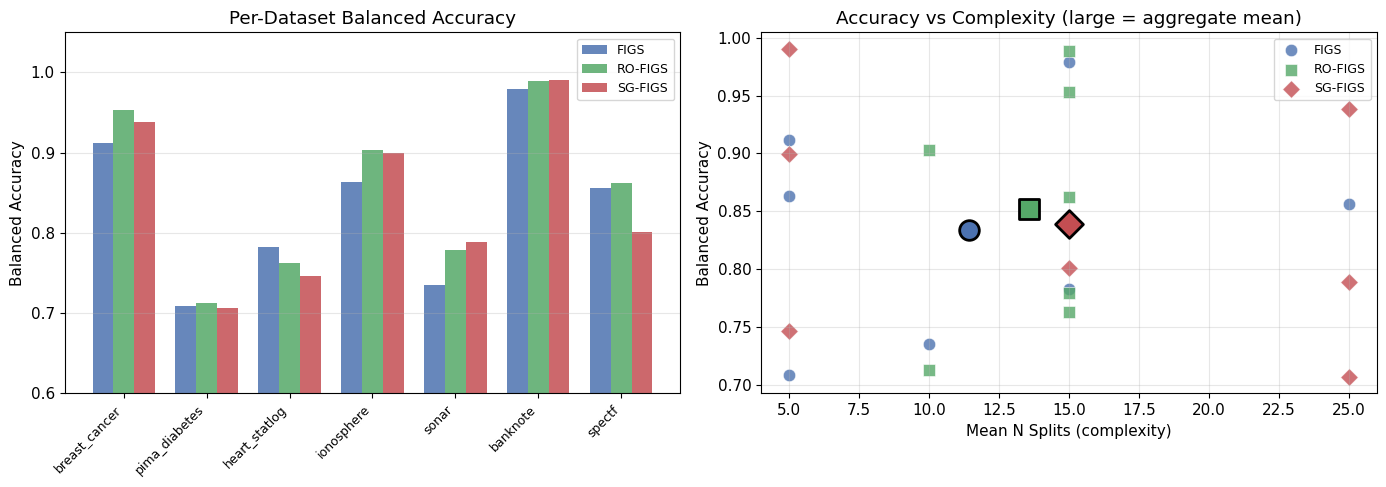


EVALUATION SUMMARY

Metric                                                  Value
-----------------------------------------------------------------
Friedman chi2                                          3.7143
Friedman p-value                                     0.156118
  Avg rank: FIGS                                       2.4286
  Avg rank: RO-FIGS                                    1.4286
  Avg rank: SG-FIGS                                    2.1429
Wilcoxon (RO vs SG) p                                0.156250
Criterion 1 pass rate                                  0.2857
Criterion 2 index mismatches                                3
Criterion 3 met                                           YES
  Efficiency: FIGS                                     0.0730
  Efficiency: RO-FIGS                                  0.0628
  Efficiency: SG-FIGS                                  0.0559
SG-FIGS on Pareto front                                    NO


In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Plot 1: Grouped bar chart of balanced accuracy ---
ax1 = axes[0]
ds_names = list(acc_per_dataset.keys())
ds_short = [d.replace("breast_cancer_wisconsin_diagnostic", "breast_cancer")
             .replace("spectf_heart", "spectf") for d in ds_names]
x = np.arange(len(ds_names))
width = 0.25
colors = ["#4C72B0", "#55A868", "#C44E52"]

for j, method in enumerate(METHODS):
    vals = [acc_per_dataset[ds].get(method, 0) for ds in ds_names]
    ax1.bar(x + j * width, vals, width, label=method, color=colors[j], alpha=0.85)

ax1.set_ylabel("Balanced Accuracy")
ax1.set_title("Per-Dataset Balanced Accuracy")
ax1.set_xticks(x + width)
ax1.set_xticklabels(ds_short, rotation=45, ha="right", fontsize=9)
ax1.legend(fontsize=9)
ax1.set_ylim(0.6, 1.05)
ax1.grid(axis="y", alpha=0.3)

# --- Plot 2: Accuracy vs Complexity (Pareto) ---
ax2 = axes[1]
markers = {"FIGS": "o", "RO-FIGS": "s", "SG-FIGS": "D"}
for j, method in enumerate(METHODS):
    acc_vals = [acc_per_dataset[ds][method] for ds in ds_names if method in acc_per_dataset[ds]]
    spl_vals = [splits_per_dataset[ds][method] for ds in ds_names if method in splits_per_dataset[ds]]
    ax2.scatter(spl_vals, acc_vals, label=method, color=colors[j],
                marker=markers[method], s=80, alpha=0.8, edgecolors="white", linewidth=0.5)

# Plot aggregate means
for j, method in enumerate(METHODS):
    if method in method_stats:
        ms = method_stats[method]
        ax2.scatter([ms["mean_splits"]], [ms["mean_accuracy"]], color=colors[j],
                    marker=markers[method], s=200, edgecolors="black", linewidth=2, zorder=5)

ax2.set_xlabel("Mean N Splits (complexity)")
ax2.set_ylabel("Balanced Accuracy")
ax2.set_title("Accuracy vs Complexity (large = aggregate mean)")
ax2.legend(fontsize=9)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# --- Summary table ---
print("\n" + "=" * 65)
print("EVALUATION SUMMARY")
print("=" * 65)
print(f"\n{'Metric':<40} {'Value':>20}")
print("-" * 65)
print(f"{'Friedman chi2':<40} {stat:>20.4f}")
print(f"{'Friedman p-value':<40} {p_value:>20.6f}")
for j, m in enumerate(METHODS):
    print(f"{'  Avg rank: ' + m:<40} {avg_ranks[j]:>20.4f}")
print(f"{'Wilcoxon (RO vs SG) p':<40} "
      f"{wilcoxon_results['RO-FIGS_vs_SG-FIGS']['p_value']:>20.6f}")
print(f"{'Criterion 1 pass rate':<40} "
      f"{(meets_both + meets_alt) / len(eligible):>20.4f}")
print(f"{'Criterion 2 index mismatches':<40} {n_mismatch:>20d}")
print(f"{'Criterion 3 met':<40} {'YES' if criterion_met else 'NO':>20}")
for m in METHODS:
    if m in method_stats:
        print(f"{'  Efficiency: ' + m:<40} "
              f"{method_stats[m]['efficiency']:>20.4f}")
print(f"{'SG-FIGS on Pareto front':<40} "
      f"{'YES' if 'SG-FIGS' in pareto_dominant else 'NO':>20}")
print("=" * 65)